In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.14.0
import tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 377.1MB 46kB/s 
     |████████████████████████████████| 3.2MB 48.4MB/s 
     |████████████████████████████████| 491kB 50.7MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


255 0


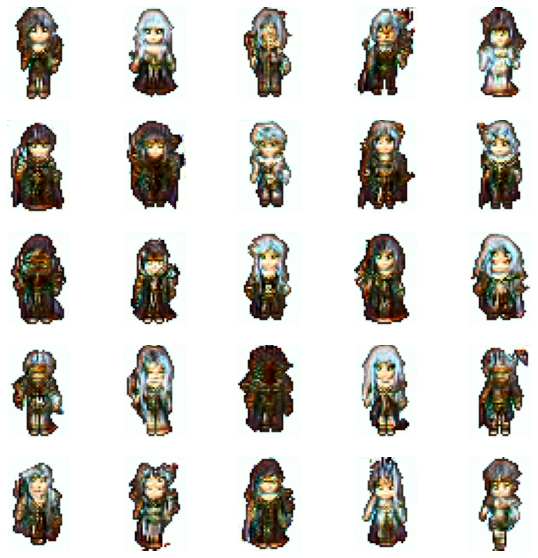

Epoch:  200
>30450, d1=-2318089216.000, d2=-2266416640.000 g=9557730304.000
>Saved: plot_048x032-tuned.png and model_048x032-tuned.h5


In [11]:
# example of progressive growing gan on celebrity faces dataset
import numpy as np
from math import sqrt
from numpy import load
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from skimage.transform import resize
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend
from matplotlib import pyplot
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from IPython import display

# pixel-wise feature vector normalization layer
class PixelNormalization(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate square pixel values
        values = inputs**2.0
        # calculate the mean pixel values
        mean_values = backend.mean(values, axis=-1, keepdims=True)
        # ensure the mean is not zero
        mean_values += 1.0e-8
        # calculate the sqrt of the mean squared value (L2 norm)
        l2 = backend.sqrt(mean_values)
        # normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        return input_shape

# mini-batch standard deviation layer
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = backend.shape(inputs)
        output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = backend.concatenate([inputs, 0.2*output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

# weighted sum output
class WeightedSum(Add):
    # init with default value
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')

    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        # ((1-a) * input1) + (a * input2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

#add a discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = max_norm(1.0)
    # get shape of existing model
    in_shape = list(old_model.input.shape)
    # define new input shape as double the size
    input_shape = (in_shape[-3].value*2, in_shape[-2].value*2, in_shape[-1].value)
    in_image = Input(shape=input_shape)
    # define new input processing layer
    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # define new block
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
    block_new = d
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    # define straight-through model
    model1 = Model(in_image, d)
    # compile model
    model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
    # downsample the new larger image
    downsample = AveragePooling2D()(in_image)
    # connect old input processing to downsampled new input
    block_old = old_model.layers[1](downsample)
    block_old = old_model.layers[2](block_old)
    # fade in output of old model input layer with new input
    d = WeightedSum()([block_old, block_new])
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    # define straight-through model
    model2 = Model(in_image, d)
    # compile model
    model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
    return [model1, model2]

# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(24,16,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = max_norm(1.0)
    model_list = list()
    # base model input
    in_image = Input(shape=input_shape)
    # conv 1x1
    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # conv 3x3 (output block)
    #d = MinibatchStdev()(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # conv 4x4
    d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # dense output layer
    d = Flatten()(d)
    out_class = Dense(1)(d)
    # define model
    model = Model(in_image, out_class)
    # compile model
    model.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
    # store model
    model_list.append([model, model])
    # create submodels
    for i in range(1, n_blocks):
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        # create new model for next resolution
        models = add_discriminator_block(old_model)
        # store model
        model_list.append(models)
    return model_list

# add a generator block
def add_generator_block(old_model):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = max_norm(1.0)
    # get the end of the last block
    block_end = old_model.layers[-2].output
    # upsample, and define new block
    upsampling = UpSampling2D()(block_end)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    # add new output layer
    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    # define model
    model1 = Model(old_model.input, out_image)
    # get the output layer from old model
    out_old = old_model.layers[-1]
    # connect the upsampling to the old output layer
    out_image2 = out_old(upsampling)
    # define new output image as the weighted sum of the old and new models
    merged = WeightedSum()([out_image2, out_image])
    # define model
    model2 = Model(old_model.input, merged)
    return [model1, model2]

# define generator models
def define_generator(latent_dim, n_blocks, in_dim_H=24, in_dim_W=16):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = max_norm(1.0)
    model_list = list()
    # base model latent input
    in_latent = Input(shape=(latent_dim,))
    # linear scale up to activation maps
    g  = Dense(128 * in_dim_H * in_dim_W, kernel_initializer=init, kernel_constraint=const)(in_latent)
    g = Reshape((in_dim_H, in_dim_W, 128))(g)
    # conv 4x4, input block
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    # conv 3x3
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    # conv 1x1, output block
    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    # define model
    model = Model(in_latent, out_image)
    # store model
    model_list.append([model, model])
    # create submodels
    for i in range(1, n_blocks):
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        # create new model for next resolution
        models = add_generator_block(old_model)
        # store model
        model_list.append(models)
    return model_list

# define composite models for training generators via discriminators
def define_composite(discriminators, generators):
	model_list = list()
	# create composite models
	for i in range(len(discriminators)):
		g_models, d_models = generators[i], discriminators[i]
		# straight-through model
		d_models[0].trainable = False
		model1 = Sequential()
		model1.add(g_models[0])
		model1.add(d_models[0])
		model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# fade-in model
		d_models[1].trainable = False
		model2 = Sequential()
		model2.add(g_models[1])
		model2.add(d_models[1])
		model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# store
		model_list.append([model1, model2])
	return model_list

#UNUSED
# load dataset
def load_real_samples(filename):
    # load dataset
    data = load(filename)
    # extract numpy array
    X = data['arr_0']
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

def random_flip(X):
  ix = np.random.binomial(1, 0.5, size=len(X))
  for i in ix:
    X[i] = np.flip(X[i], axis=1)
    
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.choice(len(dataset), size=n_samples, replace=False)
    # select images
    X = dataset[ix]
    #random_flip(X)
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
  
    # create class labels
    y = -ones((n_samples, 1))
    return X, y

# update the alpha value on each instance of WeightedSum
def update_fadein(models, step, n_steps):
    # calculate current alpha (linear from 0 to 1)
    alpha = step / float(n_steps - 1)
    # update the alpha for each model
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                backend.set_value(layer.alpha, alpha)

def show_and_save_images(X, epoch):
# Notice `training` is set to False.
# This is so all layers run in inference mode (batchnorm).
  fig = plt.figure(figsize=(10,10))
  X = np.clip(np.round((X + 1.0)*127.5),0, 255).astype(np.uint8)
  print(X.max(), X.min())
  for i in range(X.shape[0]):
    plt.subplot(5, 5, i+1)
    image = X[i]
    plt.imshow(image)
    plt.axis('off')
    if (epoch+1) % 10:
      plt.savefig('/content/drive/MyDrive/margonem/output_ProGAN/images/image_at_epoch_{:04d}.png'.format(epoch))
    if epoch >= 21:
      np.save('/content/drive/MyDrive/margonem/output_ProGAN/arrays/images_at_epoch_{:04d}.npy'.format(epoch), X)
    if epoch % 40 == 0:
      g_models[1][0].save('/content/drive/MyDrive/margonem/output_ProGAN/models/generator_at_epoch_{:04d}.h5'.format(epoch))
      d_models[1][0].save('/content/drive/MyDrive/margonem/output_ProGAN/models/discriminator_at_epoch_{:04d}.h5'.format(epoch))
      gan_models[1][0].save('/content/drive/MyDrive/margonem/output_ProGAN/models/gan_at_epoch_{:04d}.h5'.format(epoch))
  plt.show()
  print("Epoch: ", epoch)

def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein = False):
  #calculate the number of batches per training epoch
  bat_per_epo = int(dataset.shape[0] / n_batch)
  #calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  #calculate the size of half a batch of samples
  half_batch = int(n_batch / 2)
  #manually enumerate epochs
  for i in range(n_steps): 
    #update alpha for all WeightedSum layers when fading in new blocks
    if fadein:
            update_fadein([g_model, d_model, gan_model], i, n_steps)# prepare real and fake samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)# which_epoch(n_steps, n_epochs, X_fake)# update discriminator model
    d_loss1 = d_model.train_on_batch(X_real, y_real)
    d_loss2 = d_model.train_on_batch(X_fake, y_fake)# update the generator via the discriminator 's error
    z_input = generate_latent_points(latent_dim, n_batch)
    y_real2 = ones((n_batch, 1))
    g_loss = gan_model.train_on_batch(z_input, y_real2)# summarize loss on this batch
    X, y = generate_fake_samples(g_model, latent_dim, 25)
    which_epoch(i, bat_per_epo, X)
    print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, d_loss1, d_loss2, g_loss))
  
def which_epoch(step, steps_per_epo, X):
  global epoch
  if (step+1) % steps_per_epo == 0:
    epoch = epoch + 1
    display.clear_output(wait=True)
    show_and_save_images(X, epoch)
    
# scale images to preferred size
def scale_dataset(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# generate samples and save as a plot and save the model
def summarize_performance(status, g_model, latent_dim, n_samples=25):
    # devise name
    gen_shape = g_model.output_shape
    name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
    # generate images
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # normalize pixel values to the range [0,1]
    X = (X - X.min()) / (X.max() - X.min())
    # plot real images
    square = int(sqrt(n_samples))
    for i in range(n_samples):
        pyplot.subplot(square, square, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i])
    # save plot to file
    filename1 = 'plot_%s.png' % (name)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%s.h5' % (name)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
    # fit the baseline model
    g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
    # scale dataset to appropriate size
    gen_shape = g_normal.output_shape
    scaled_data = scale_dataset(dataset, gen_shape[1:])
    print('Scaled Data', scaled_data.shape)
    # train normal or straight-through models
    train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0])
    summarize_performance('tuned', g_normal, latent_dim)
    # process each level of growth
    for i in range(1, len(g_models)):
        # retrieve models for this level of growth
        [g_normal, g_fadein] = g_models[i]
        [d_normal, d_fadein] = d_models[i]
        [gan_normal, gan_fadein] = gan_models[i]
        # scale dataset to appropriate size
        gen_shape = g_normal.output_shape
        scaled_data = scale_dataset(dataset, gen_shape[1:])
        print('Scaled Data', scaled_data.shape)
        
        # train fade-in models for next level of growth
        train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True)
        summarize_performance('faded', g_fadein, latent_dim)
        # train normal or straight-through models
        train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i])
        summarize_performance('tuned', g_normal, latent_dim)

# number of growth phases, e.g. 6 == [4, 8, 16, 32, 64, 128]
n_blocks = 2
# size of the latent space
latent_dim = 512
# define models
d_models = define_discriminator(n_blocks)
# define models
g_models = define_generator(latent_dim, n_blocks)
# define composite models
gan_models = define_composite(d_models, g_models)
# load image data
input_path = '/content/drive/MyDrive/margonem/full_dataset.npy'
dataset = np.load(input_path)

background_percentage = []
for image in dataset:
  height = image.shape[0]
  width = image.shape[1]
  pixels_nr = width * height
  if image.shape[2] == 4:   
      non_background_pixels_count = (image[:, :, 3] != 0).sum()
      image_background_percentage = 1.0 - non_background_pixels_count / pixels_nr
      background_percentage.append(image_background_percentage)
    
background_percentage = np.array(background_percentage)
quantiles = np.quantile(background_percentage, (0.1, 0.95))
mask = (background_percentage >= quantiles[0]) & (background_percentage <= quantiles[1])
dataset = dataset[mask]

dataset = dataset[:,:,:,:-1]
print('Loaded', dataset.shape)
n_batch = [16, 16]
# 10 epochs == 500K images per training phase
n_epochs = [25, 150]
n_fadein = [16, 25]
epoch = 0
train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_fadein, n_batch)